In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [39]:
df = pd.read_csv("combined_league_matches.csv")
character_columns = [f'red_champion_{i}' for i in range(5)] + [f'blue_champion_{i}' for i in range(5)]
df = pd.get_dummies(df, columns=character_columns)

mastery_columns = [
    'red_mastery_0', 'red_mastery_1', 'red_mastery_2', 'red_mastery_3', 'red_mastery_4',
    'blue_mastery_0', 'blue_mastery_1', 'blue_mastery_2', 'blue_mastery_3', 'blue_mastery_4'
]

scaler = StandardScaler()
df[mastery_columns] = scaler.fit_transform(df[mastery_columns])

df['target'] = df['winner'].apply(lambda x: 1 if x == 'blue' else 0)

X = df.drop(columns=['match_id', 'winner', 'target']).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [40]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
batch_size = 32
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.1)        

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

In [42]:
# Model, loss function, and optimizer

input_size = X_train.shape[1]
model = NeuralNet(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

#Evaluation
model.eval()
with torch.no_grad():
    y_preds = []
    y_true = []

    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch).squeeze()
        y_preds.extend(y_pred.round().numpy())
        y_true.extend(y_batch.numpy())

#accuracy
accuracy = accuracy_score(y_true, y_preds)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/30, Loss: 58.0750
Epoch 2/30, Loss: 58.0154
Epoch 3/30, Loss: 57.8755
Epoch 4/30, Loss: 57.5096
Epoch 5/30, Loss: 57.1483
Epoch 6/30, Loss: 56.8332
Epoch 7/30, Loss: 56.5209
Epoch 8/30, Loss: 56.3204
Epoch 9/30, Loss: 56.2150
Epoch 10/30, Loss: 56.1211
Epoch 11/30, Loss: 56.0425
Epoch 12/30, Loss: 55.9024
Epoch 13/30, Loss: 55.8940
Epoch 14/30, Loss: 55.7908
Epoch 15/30, Loss: 55.7335
Epoch 16/30, Loss: 55.7236
Epoch 17/30, Loss: 55.6315
Epoch 18/30, Loss: 55.6397
Epoch 19/30, Loss: 55.6631
Epoch 20/30, Loss: 55.5589
Epoch 21/30, Loss: 55.5233
Epoch 22/30, Loss: 55.4333
Epoch 23/30, Loss: 55.4548
Epoch 24/30, Loss: 55.3952
Epoch 25/30, Loss: 55.3869
Epoch 26/30, Loss: 55.4880
Epoch 27/30, Loss: 55.4483
Epoch 28/30, Loss: 55.2915
Epoch 29/30, Loss: 55.2872
Epoch 30/30, Loss: 55.2208
Test Accuracy: 0.53


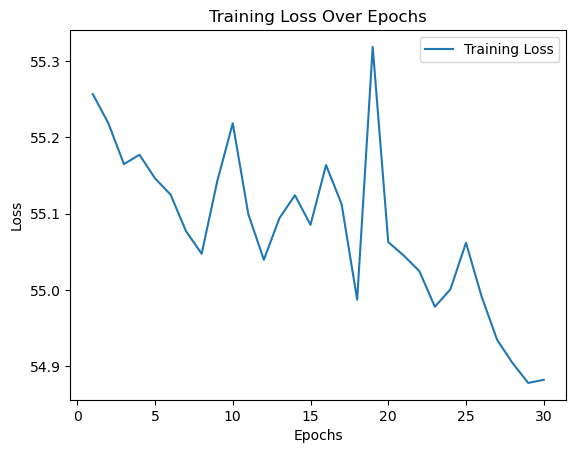

In [43]:
#should actually plot training loss and validation loss to overfit check
loss_values = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    loss_values.append(epoch_loss / len(train_loader))

# Plot
plt.plot(range(1, num_epochs+1), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()